# Mask Detection. Faster R-SNN vs. YOLOv8

## Transfer learning of two pretrained models from the Faster R-CNN and YOLO families

This notebook is [available on Kaggle](https://www.kaggle.com/code/dkudryavtsev/mask-detection-faster-r-snn-vs-yolov8).

The notebook presents an instance of object detection problem solution using the two popular models mentioned in the title. The last one is a pretty newborn version as of this date (June 2023).

The following cases can be found below:
* object detection with Faster R-CNN
* object detection with YOLO version 8
* work with hardly imbalanced classes (3% and 18% for the minor classes)
* not only hardly imbalanced, but locating in the same image
* meditation for hours at loss functions falling in real time with your own matplotlib figure
* the same but with the Wandb logging service, implemented by default in YOLOv8, (API Key for Wandb is needed, it's free)

The project is based on the Kaggle [Face Mask Detection](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection) dataset. Three classes are presented: with mask, without mask, mask weared incorrectly.

In [1]:
#########1#########2#########3#########4#########5#########6#########7#########
import numpy as np
import pandas as pd
import torch
import torchvision
import xml.etree.ElementTree as ET
import random
import os
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import shutil
import wandb
from kaggle_secrets import UserSecretsClient
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from pathlib import Path
from IPython.display import display, clear_output
from pprint import pprint

!pip install ultralytics
from ultralytics import YOLO

# Matplotlib figures with white background, not transparent
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Assigning the GPU for computations, if it exists
# (actually with CPU one is going to calculate it to the end of time)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Choosing between Kaggle and a local machine
DATA = Path(
    #'/home/dkudr/data/CV_datasets/FaceMaskDetection')
    '/kaggle/input/face-mask-detection')
SAVED_RESULTS = Path(
    #'/home/dkudr/Yandex.Disk/Development/cv_engineering/CV_Project2')
    '/kaggle/input/mask-detection')
WORKING = Path(
    #'/home/dkudr/Yandex.Disk/Development/cv_engineering/CV_Project2')
    '/kaggle/working')
YOLO_DATA =  Path(
    #'/home/dkudr/data/CV_datasets/FaceMaskDetection/yolov8')
    '/kaggle/working/yolov8')

FRCNN_BATCH_SIZE = 4

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.1/593.1 kB 15.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 17.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60


## 1. Data Readout

In [2]:
# Dataset structure
!tree -d {DATA}

/kaggle/input/face-mask-detection
├── annotations
└── images

2 directories


The annotations are in XML format, the images are PNG files. Here we make a table (datafreme) with image names and bounding box parameters in them. This dataframe is a simple representation of our dataset, evident and usefull for further data manipulations.

In [3]:
def xml_to_df(path=DATA/'annotations'):
    xml_list = []
    
    for file in tqdm(sorted(path.glob('*.xml'))):
        tree = ET.parse(file)
        root = tree.getroot()
        imsize = root.find('size')
        width = int(imsize.find('width').text)
        height = int(imsize.find('height').text)
                
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text
            value = (root.find('filename').text,
                     width,
                     height,
                     xmin,
                     ymin,
                     xmax,
                     ymax,
                     label
                    )
            xml_list.append(value)
    
    columns = [
        'filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax', 'class']
    xml_df = pd.DataFrame(xml_list, columns=columns)
    
    
    # Some bboxes are out of an image by 1 pixel, correcting:
    xml_df['xmax'] = xml_df.apply(
        lambda x: x['width'] if x['xmax'] > x['width'] else x['xmax'], axis=1)
        
    # Dropping tiny bounding boxes
    xml_df['area'] = ((xml_df['xmax'] - xml_df['xmin']) 
                      * (xml_df['ymax'] - xml_df['ymin']))
    xml_df = xml_df[xml_df['area']>20]
        
    return xml_df


bboxes_df = xml_to_df()
display(bboxes_df.head())
print(f"Number of images: {bboxes_df['filename'].nunique()}")
print(f'Number of objects: {bboxes_df.shape[0]}\n')
nobj_in_class =  bboxes_df.groupby('class')['xmin'].count()
print(nobj_in_class)

100%|██████████| 853/853 [00:02<00:00, 303.87it/s]


filename  width  height  xmin  ymin  xmax  ymax         class  \
0  maksssksksss0.png    512     366    79   105   109   142  without_mask   
1  maksssksksss0.png    512     366   185   100   226   144     with_mask   
2  maksssksksss0.png    512     366   325    90   360   141  without_mask   
3  maksssksksss1.png    400     156   321    34   354    69     with_mask   
4  maksssksksss1.png    400     156   224    38   261    73     with_mask   

   area  
0  1110  
1  1804  
2  1785  
3  1155  
4  1295

Number of images: 853
Number of objects: 4054

class
mask_weared_incorrect     123
with_mask                3216
without_mask              715
Name: xmin, dtype: int64


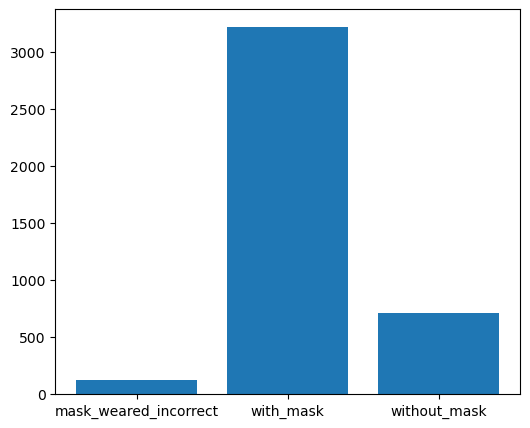

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.bar(nobj_in_class.index, nobj_in_class);

The classes are hugely imbalanced! We risk to get stuck with bad detection of COVID criminals. One of the ways to struggle with this is the weighted loading of data during model training: for each image file we need to assign the probability (weight) with which the dataloader will later choose it. The weights must be inversionally proportional to the incidence of a class. Minding that one file can contain several different classes, the "mean inverse probability" per image is calculated.

In [4]:
wdict = {'with_mask': 1 - 3216/4054,
         'without_mask': 1 - 715/4054,
         'mask_weared_incorrect': 1 - 123/4054
         }

bboxes_df['im_weight'] = bboxes_df['class'].replace(wdict)
bboxes_df['im_weight'] = (bboxes_df
                          .groupby('filename')['im_weight'].transform('mean'))

We encode the classes with labels and make a stratified splitting of the images into the training and validation samples, the image weights are taken into account in the splitting. 

Notice that Faster R-CNN is trained in such a way that its weights "know" about a special *background* class, and this class is labelled 0. Therefore we must assign our custom labels starting from 1, otherwise the model will simply ignore the "zero" class. This is not very clear from the official PyTorch documentation. 

In [5]:
encoder = LabelEncoder()
bboxes_df['label'] =  encoder.fit_transform(bboxes_df['class'])
bboxes_df['label'] = bboxes_df['label'] + 1
labels_dict = dict(zip(range(1, len(encoder.classes_) + 1), encoder.classes_))

# Categorical image type based on the weight range is for stratified splitting 
bboxes_df['im_type'] = (bboxes_df['im_weight'].astype(str)
                        .apply(lambda x: x[:3]))

# Splitting by filenames and the weight range
unique_names_df = bboxes_df[['filename', 'im_type']].drop_duplicates()
train_fnames, valid_fnames = train_test_split(unique_names_df, 
    train_size=0.8, stratify=unique_names_df['im_type'], random_state=42)
train_df = (bboxes_df[bboxes_df['filename']
                      .isin(train_fnames['filename'])].copy())
valid_df = (bboxes_df[bboxes_df['filename']
                      .isin(valid_fnames['filename'])].copy())

print('Training dataset:')
print(f"Number of images: {train_df['filename'].nunique()}")
print(f'Number of objects: {train_df.shape[0]}\n')
print(train_df.groupby('class')['xmin'].count() / len(train_df))

print('\n---\n\nValidation dataset:')
print(f"Number of images: {valid_df['filename'].nunique()}")
print(f'Number of objects: {valid_df.shape[0]}\n')
print(valid_df.groupby('class')['xmin'].count() / len(valid_df))

Training dataset:
Number of images: 682
Number of objects: 3312

class
mask_weared_incorrect    0.031703
with_mask                0.797101
without_mask             0.171196
Name: xmin, dtype: float64

---

Validation dataset:
Number of images: 171
Number of objects: 742

class
mask_weared_incorrect    0.024259
with_mask                0.776280
without_mask             0.199461
Name: xmin, dtype: float64


The proportion of the classes in the training and validation samples are quite similar (we cannot get exactly equal proportions, because we are dividing images, not classes).

The augmentations. We select those after which an original image doesn't differ too much from a typical dataset image. The Albumentation library is used, it can adjust the bounding boxes after geometric transformations.

The augmentations combined with the weighted loading of data could  potentially help oversample our deficient data on minor classes.

In [6]:
transforms_train = A.Compose([
    A.HorizontalFlip(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.ISONoise(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
        A.AdvancedBlur(p=0.1)
    ]),
    ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', label_fields=['labels'], min_area=21))

transforms_valid = ToTensorV2()

Making a PyTorch dataset

In [7]:
class FaceMaskDataset(torch.utils.data.Dataset):
    """The class creates a custom dataset in Pytorch format.
       The most important function here is __getitem__, 
       which returns a single object from our raw data 
    """
    
    def __init__(self, df, imdir, transforms):
        """ df: Pandas DataFrame
            imdir: Pathlib Path to the image folder
            transforms: transformations
            mode: 'train' of 'valid' dataset
        """
        self.df = df
        self.imdir = imdir
        self.imnames = df['filename'].unique()
        self.transforms = transforms
                    
    
    def __getitem__(self, idx):
        """ Returns an image (PyTorch Tensor) and its target values:
            a dict with bboxes (tensor) and object labels (tensor)
        """
        imname = self.imnames[idx]
        
        # Reading in an image
        image = cv2.imread(str(self.imdir/imname))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        
        # Augmentation 
        mask = self.df['filename'] == imname
        bboxes = np.array(self.df[mask][['xmin', 'ymin', 'xmax', 'ymax']])
        labels = np.array((self.df[mask]['label']))
        transformed = self.transforms(
            image=image, bboxes=bboxes, labels=labels)
                        
        # Output for the model 
        image = transformed['image'] 
        bboxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float16)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
        target = {'boxes': bboxes, 'labels': labels}
                        
        # Normalization
        image = image / 255
               
        return image, target
    
    
    def __len__(self):
        return len(self.imnames)

In [8]:
train_dataset = FaceMaskDataset(train_df, DATA/'images', transforms_train)
valid_dataset = FaceMaskDataset(valid_df, DATA/'images', transforms_valid)

"""Checking if everything is OK with dataset readout,
   commented after the first use
""" 
#for el in tqdm(train_dataset):
#    pass
#for el in tqdm(valid_dataset):
#    pass

Constructing dataloaders. Here we need a custom collation function because our images have different sizes (they will be stardardized later by the model) but by default DataLoader expects arrays of the same size to make tensors out of them. We, insted, make tuples out of individual batch samples, and feeding them into the model will be realized in the training procedure.

We use the Weighted Random Sampler here so that minor classes had more chances to be presented to the model, according to their weights that we've calculated earlier. 

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Weights
im_weights_train = torch.as_tensor(
    np.array(train_df.drop_duplicates(subset='filename')['im_weight']), 
    dtype=torch.float16)
im_weights_valid = torch.as_tensor(
    np.array(valid_df.drop_duplicates(subset='filename')['im_weight']), 
    dtype=torch.float16)

# Sampler
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    im_weights_train, len(im_weights_train))
valid_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    im_weights_valid, len(im_weights_valid))

# Data loaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=FRCNN_BATCH_SIZE,
    sampler=train_sampler,
    num_workers=os.cpu_count(),
    collate_fn=collate_fn
)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=FRCNN_BATCH_SIZE,
    sampler=valid_sampler,
    num_workers=os.cpu_count(),
    collate_fn=collate_fn
)

Let's look at our data after all the preparations.

In [10]:
def image_convert(image):
    """Converts a torch.Tensor to a "H,W,C" array of integers [0-255]
    """
    image = image.numpy()
    image = image.transpose((1, 2, 0))
    image = (image * 255).astype(np.uint8)
    return image

  
def plot_imgs(dataloader, n_images=5):
    """Shows first 'n_images' from a batch
       created by a 'dataloader'    
    """
    batch = next(iter(dataloader))
    assert n_images <= len(batch[0]), 'No. of images greater than batch size'
    images = batch[0][:n_images]
    targets = batch[1][:n_images]
    
    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
    for idx, ax in zip(range(n_images), axes):
        image = image_convert(images[idx])
        image = np.ascontiguousarray(image)
        bboxes = targets[idx]['boxes']
        labels = targets[idx]['labels'].numpy()
        for i, bbox in enumerate(bboxes):
            xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]), 
                                      int(bbox[2]), int(bbox[3]))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), 
                          (0, 255, 0), thickness=2)
            text = ax.text(xmin, ymin, f'{labels_dict[labels[i]]}', 
                    fontsize=14, color='w')
            text.set_bbox(dict(facecolor='b', alpha=0.4, edgecolor='b'))
        ax.axis('off')
        ax.imshow(image)

Four random images augmented and loaded by the dataloader. The minor classes, in theory, should have equal chances to be represented here. This is not exactly the thuth, as the classes are mixed in an image. Each runnung of the cell below refreshes the images.

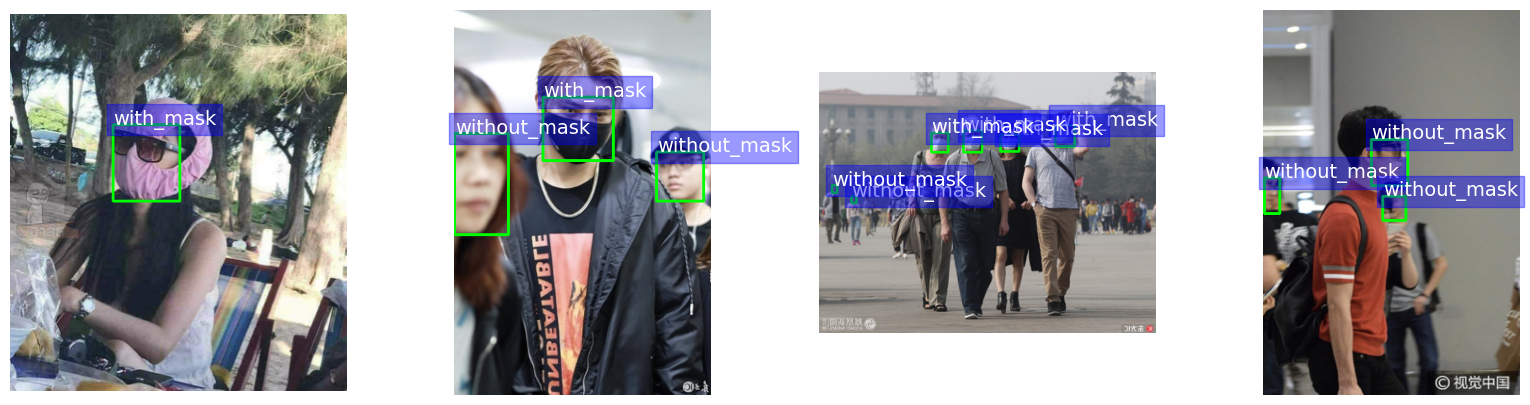

In [11]:
plot_imgs(train_dataloader, 4)

---

## 2. Faster R-CNN

There are four models of the Faster R-CNN family in the standard PyTorch library, two are based on the Resnet-50-FPN backbone and two on MobileNetV3. The MobileNet-based models  are designed for mobile vision applications (lower hardware requirements). Here we use the standard Resnet-50-FPN backbone with 41.8 mln parameters, 134.38 GFLOPS, which is the lighter version of the two Resnet-50-FPN models. By default, the model is loaded with three trainable (not frozen) backbone layers starting from the final block.

In [12]:
# Reading in the pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

# New predictor with the background (class 0) and 3 classes (thus four as a total)
model.roi_heads.box_predictor = FastRCNNPredictor(1024, 4)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 64.6MB/s] 


Model training procedures. The train_model function also refreshes the loss functions plot after each epoch (wait untill epoch 1 is finished to see the curves).

In [13]:
def process_epoch(model, optimizer, dataloader, mode='eval'):
    """Processing an epoch,
       returns a loss function for an epoch    
    """
    if mode == 'train':
        # gradient calculations on
        torch.set_grad_enabled(True)
    else:
        # gradient calculations off
        torch.set_grad_enabled(False)
      
    batch_losses = []   # Loss function values for each batch
       
    for images, targets in dataloader:
        """copying batch data values to GPU/CPU
           and organizing them in the way needed for the model"""
        images = list(image.to(device) for image in images)
        targets = list({key: val.to(device) for key, val in target.items()} 
                       for target in targets)
                
        # forward propagation 
        loss_dict = model(images, targets)
        
        # model returns 4 fifferent losses, we are summing them up
        model_losses = sum(loss_val for loss_val in loss_dict.values())
        
        # .item() is convertion from a tensor to a simple value
        batch_losses.append(model_losses.item())   
        
        # training step
        if mode == 'train':
            optimizer.zero_grad()
            model_losses.backward()
            optimizer.step()
    
    return np.mean(batch_losses)
      

def train_model(model, optimizer, train_loader, valid_loader, num_epochs=10):
    """Model training
    """
    # Lists to save loss function values and accuracy per an epoch
    train_loss, valid_loss = [], []
    
    fig, ax = plt.subplots(figsize=(8, 5))
        
    # model to the train mode
    model.train()
    
    for epoch in range(num_epochs):
        loss = process_epoch(model, optimizer, train_loader, mode='train')
        train_loss.append(loss)
        loss = process_epoch(model, optimizer, valid_loader, mode='eval')
        valid_loss.append(loss)
        
        for _ in range(len(ax.lines)):
            ax.lines[0].remove()
        x_max = len(train_loss)
        ax.plot(range(x_max), train_loss, color='b', label='train')
        ax.plot(range(x_max), valid_loss, color='r', label='valid')
        ax.legend()
        ax.set_title('Loss functions')
        ax.set_xlabel('Epochs')
        display(fig)
        clear_output(wait=True)
                           
    torch.set_grad_enabled(True)  # back to normal behavior
    return train_loss, valid_loss

Model training and saving the results. For 50 epochs, about 2 hours with GPU P100 on Kaggle. The validation loss function stays still after about 20 epochs. 

CPU times: user 1h 55min 35s, sys: 1min, total: 1h 56min 35s
Wall time: 1h 59min 49s


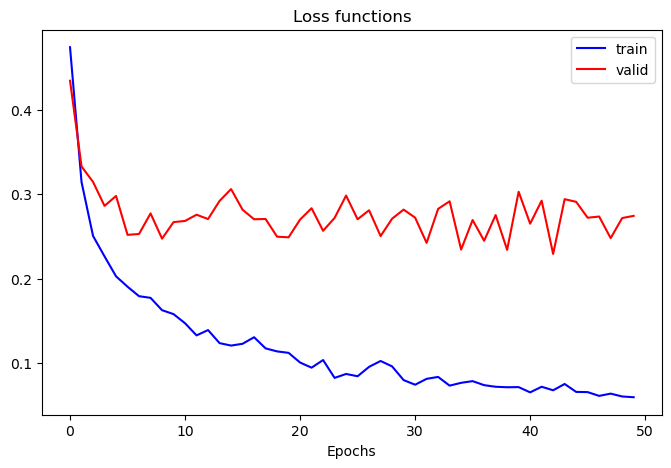

<Figure size 1600x500 with 0 Axes>

In [14]:
%%time
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=0.005, momentum=0.9, weight_decay=0.0005)

train_loss, valid_loss = train_model(
    model, optimizer, train_dataloader, valid_dataloader, num_epochs=50)

# Saving the trained weights
torch.save(model.state_dict(), WORKING/'fasterrcnn.pt')

In [ ]:
"""In case the saved weights are to be loaded in a new kernel"""
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
#model.roi_heads.box_predictor = FastRCNNPredictor(1024, 4)
#model.load_state_dict(torch.load(SAVED_RESULTS/'fasterrcnn.pt'))
#model.eval()

Functions to preprocess and plot the predictions

In [11]:
def apply_nms(orig_prediction, iou_thresh=0.7):
    """Non-maximum supression:
       deleting lower-confidence bboxes overlapped with iou > iou_thres
    """
    keep = torchvision.ops.nms(
        orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction 


def drop_low_confidence(orig_prediction, conf_thresh=0.25):
    """ Dropping bboxes with low confidence scores
    """
    keep = []
    for idx, conf in enumerate(orig_prediction['scores']):
        if conf > conf_thresh:
            keep.append(idx)
    high_conf_preds = orig_prediction
    high_conf_preds['boxes'] = high_conf_preds['boxes'][keep]
    high_conf_preds['scores'] = high_conf_preds['scores'][keep]
    high_conf_preds['labels'] = high_conf_preds['labels'][keep]
    
    return high_conf_preds


def plot_predict(model, dataloader, n_images=4):
    """Shows first 'n_images' from a batch
       with the ground truth (green) and prediction (red) bboxes  
    """
    batch = next(iter(dataloader))
    assert n_images <= len(batch[0]), 'No. of images greater than batch size'
    images = batch[0][:n_images]
    targets = batch[1][:n_images]
        
    # Make a prediction, CPU is used
    model = model.to('cpu')
    model.eval()
    with torch.no_grad():
        preds = model(list(images))
            
    # Plotting
    fig, axes = plt.subplots(1, n_images, figsize=(10*n_images, 10))
    for idx, ax in zip(range(n_images), axes):
        image = image_convert(images[idx])
        image = np.ascontiguousarray(image)
        bboxes_true = targets[idx]['boxes']
        
        # Extracting bboxes, confidence scores, and labels
        high_conf_preds = drop_low_confidence(preds[idx])
        final_preds = apply_nms(high_conf_preds)
        bboxes_pred = final_preds['boxes']
        labels = final_preds['labels'].numpy()
        scores = final_preds['scores'] * 100
                
        # Ground truth bboxes
        for i, bbox in enumerate(bboxes_true):
            xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]), 
                                      int(bbox[2]), int(bbox[3]))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), 
                          (0, 255, 0), thickness=1)
                    
        # Predictions with labels and confidence
        for i, bbox in enumerate(bboxes_pred):
            xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]), 
                                      int(bbox[2]), int(bbox[3]))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), 
                          (255, 0, 0), thickness=1)
            text = ax.text(xmin, ymin, f'{labels_dict[labels[i]]}: {int(scores[i])}%',
                           fontsize=14, color='w')
            text.set_bbox(dict(facecolor='b', alpha=0.2, edgecolor='b'))
                    
        ax.axis('off')
        ax.imshow(image)

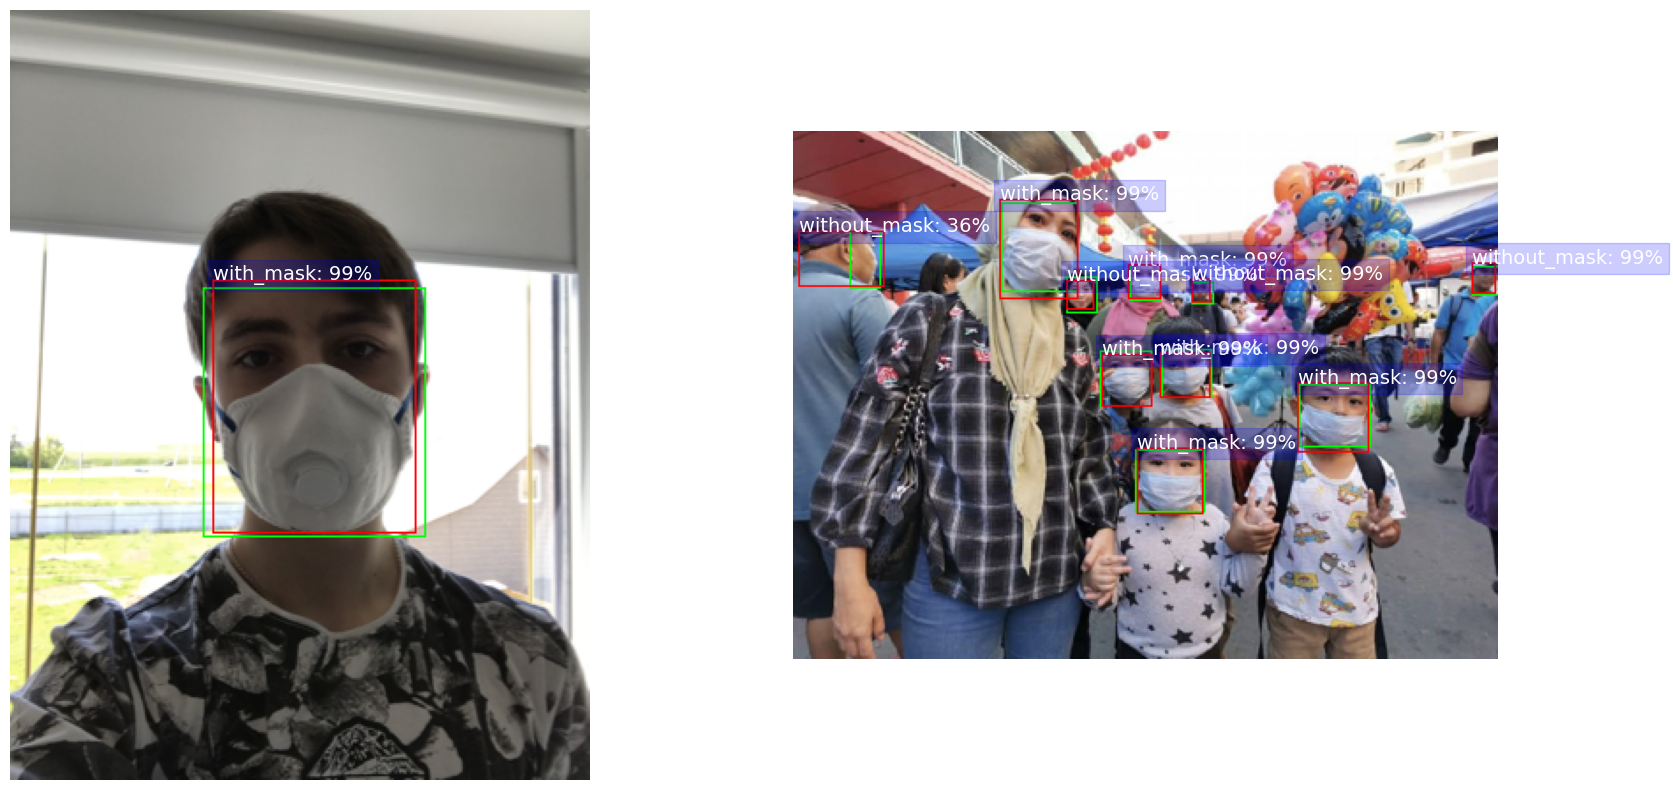

In [24]:
plot_predict(model, valid_dataloader, 2)

Function to compute the mean average precision and some other metrics over a dataset. A dataloader is used to get the images.

In [25]:
def compute_mAP(model, dataloader):
    """Computing the mean average precision over a dataset
    """
    total_preds = []
    total_grtruths = []
    for images, targets in tqdm(dataloader):
        images = list(image.to(device) for image in images)
        targets = list(targets)
        total_grtruths.extend(targets)
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            preds = model(images)
        preds = list({key: val.to('cpu') for key, val in pred.items()} 
                       for pred in preds)
        high_conf_preds = list(drop_low_confidence(pred) for pred in preds)
        final_preds = list(apply_nms(pred) for pred in high_conf_preds)
        total_preds.extend(final_preds)
        
    mAP = MeanAveragePrecision(class_metrics=True)
    mAP.update(total_preds, total_grtruths)
    return mAP.compute()      

Our valid_dataloader loads data in a randomized weighted manner. For metrics evaluation we need the normal sequential loading.

In [26]:
metric_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=FRCNN_BATCH_SIZE,
    num_workers=os.cpu_count(),
    collate_fn=collate_fn
)

mAP = compute_mAP(model, metric_dataloader)
pprint(mAP)

100%|██████████| 43/43 [00:15<00:00,  2.77it/s]


{'map': tensor(0.5266),
 'map_50': tensor(0.7869),
 'map_75': tensor(0.6270),
 'map_large': tensor(0.7470),
 'map_medium': tensor(0.5289),
 'map_per_class': tensor([0.3855, 0.6449, 0.5492]),
 'map_small': tensor(0.5071),
 'mar_1': tensor(0.2603),
 'mar_10': tensor(0.5629),
 'mar_100': tensor(0.5820),
 'mar_100_per_class': tensor([0.4000, 0.7122, 0.6338]),
 'mar_large': tensor(0.7630),
 'mar_medium': tensor(0.6107),
 'mar_small': tensor(0.5753)}


The mean average precision (area under the precision-recall curve) over the classes in the validation dataset is 0.53. The mean average precision at IOU=50% is 0.79. The metrics are not that good because of the underrepresented minor classes in the dataset, see the map_per_class list. Nevertheless, it's a fair enough result for the situation where the minor classes are represented at the 3% and 18% levels compared to 79% of the major class. I think it definitely could have been worse without the weighted training.

---

## 3. YOLOv8

This is the new state-of-the-art version of the "You Only Look Once" models family. Unlike in the previous case of manual transmission, here the job of a data scientist is basically the copy-pasting of images from one folder to another. Here we go.

In [12]:
def convert_to_yolov8(df, train):
    """ Creating annotations and copying selected images to 
        special "train-valid" folders for further YOLO training
    """
    # bboxes coordinates to YOLO format
    df['x_center'] = (df['xmin'] + df['xmax']) / 2 / df['width']
    df['y_center'] = (df['ymin'] + df['ymax']) / 2 / df['height']
    df['bb_width'] = (df['xmax'] - df['xmin']) / df['width']
    df['bb_height'] = (df['ymax'] - df['ymin']) / df['height']
    
    for image in tqdm(df['filename'].unique()):
        if train:
            imfolder = YOLO_DATA/'images/train'
            label_folder = YOLO_DATA/'labels/train'
        else:
            imfolder = YOLO_DATA/'images/valid'
            label_folder = YOLO_DATA/'labels/valid'
        
        # copying an image to the YOLO folder
        shutil.copy(DATA/'images'/image, imfolder)
        
        # making a YOLO .txt file with the bounding boxes parameters
        mask = df['filename'] == image
        out_df = (df[mask][['label', 'x_center', 'y_center', 
                            'bb_width', 'bb_height']])
        filename = label_folder/image.replace('png', 'txt')
        out_df.to_csv(filename, sep=' ', header=False, index=False)

In YOLO, the labels of the classes must start from 0, this is different from the Faster R-CNN approach.

In [14]:
# New numeration of the labels
train_df['label'] = train_df['label'] - 1
valid_df['label'] = valid_df['label'] - 1
labels_dict = dict(zip(range(len(encoder.classes_)), encoder.classes_))


# To YOLO v8
Path(YOLO_DATA/'images/train').mkdir(parents=True, exist_ok=True)
Path(YOLO_DATA/'images/valid').mkdir(parents=True, exist_ok=True)
Path(YOLO_DATA/'labels/train').mkdir(parents=True, exist_ok=True)
Path(YOLO_DATA/'labels/valid').mkdir(parents=True, exist_ok=True)
convert_to_yolov8(train_df, train=True)
convert_to_yolov8(valid_df, train=False)

100%|██████████| 171/171 [00:02<00:00, 74.09it/s]


Writing a configuration file for our custom dataset

In [15]:
text = """
names:
  0: weared_incorrectly
  1: mask
  2: no_mask
"""

with open('mask_detection.yaml', 'w') as f:
    f.write(f"train: {YOLO_DATA/'images/train'}\n")
    f.write(f"val: {YOLO_DATA/'images/valid'}\n")
    f.write(text)

Reading in a pretrained YOLO model. I've choosen the ["medium" model](https://docs.ultralytics.com/tasks/detect/#models) with $26~$mln parameters as a tradeoff between the high performance (mAP50-95$~=0.5$ on COCO dataset) and the $79$ GFLOPs. The next-grade model takes $165$ GFLOPS (two times more) with $3\%$ of mAP growth (to $0.53$).

Next, I authorize on Wandb with my API key. Wandb is a nice and user-friendly free web service where the YOLO training procedure is, by default, going to stack various logging stuff like loss function graphs, metrics, GPU overhitting, and so on. 

In [16]:
# Loading a pretrained model
model = YOLO('yolov8m.pt')

# Authorizing on the Wandb logging service
# Tutorial for Kaggle:
# https://www.kaggle.com/code/samuelcortinhas/weights-biases-tutorial-beginner
user_secrets = UserSecretsClient()
key = user_secrets.get_secret('wandb_api_key') 
wandb.login(key=key)

100%|██████████| 49.7M/49.7M [00:01<00:00, 38.2MB/s]
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

This is the training. Batch -1 means that the batch size is calculated automatically. You can look at the Wandb logs and graphics in real time during the training, and, of course, afterwards: https://wandb.ai/masterbias/YOLOv8/ (a public log for this kernel running, "Confused Darkness" they named it).

In [17]:
%%time
model.train(
    data='mask_detection.yaml', batch=-1, epochs=100, workers=os.cpu_count())

Ultralytics YOLOv8.0.112 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=mask_detection.yaml, epochs=100, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=2, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic

AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
100%|██████████| 6.23M/6.23M [00:00<00:00, 24.6MB/s]
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.90G total, 0.26G reserved, 0.23G allocated, 15.42G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    25858057           0         2.177           165         376.3        (1, 3, 640, 640)                    list
    25858057           0         1.955         114.2           141        (2, 3, 640, 640)                    list
    25858057           0         2.716         82.39         166.8        (4, 3, 640, 640)                    list
    25858057           0         4.360         116.4           233        (8, 3, 640, 640)                    list
    25858057           0         8.693         158.8         426.2       (16, 3, 640, 640)                    list
AutoBatch: Usi

CPU times: user 49min 52s, sys: 1min 52s, total: 51min 44s
Wall time: 55min 44s


The mean average precision (area under the IOU 0.5-0.95 precision-recall curve) is 0.68. The mean average precision at IOU=50% is 0.92. The most badly represented class ("masks weared incorrectly") gives mAP50=0.89. These are much better results than in the previous case. The discussion is in the conclusion. Now let's just look at some pictures.

In [18]:
def plot_predict_yolo(model, dataloader, n_images=2):
    """Shows first 'n_images' from a batch
       with ground truth (green) and prediction (red) bboxes  
    """
    batch = next(iter(dataloader))
    assert n_images <= len(batch[0]), 'No. of images greater than batch size'
    images = batch[0][:n_images]
    targets = batch[1][:n_images]
    
    fig, axes = plt.subplots(1, n_images, figsize=(10*n_images, 10))
    for idx, ax in zip(range(n_images), axes):
       image = image_convert(images[idx])
       image = np.ascontiguousarray(image)
       with torch.no_grad():
           preds = model(image)
       
       bboxes_true = targets[idx]['boxes']
       bboxes_pred = preds[0].boxes.xyxy.to('cpu')
       labels = preds[0].boxes.cls.to('cpu').numpy()
       scores = preds[0].boxes.conf.to('cpu') * 100
      
       # Ground truth bboxes
       for i, bbox in enumerate(bboxes_true):
           xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]), 
                                     int(bbox[2]), int(bbox[3]))
           cv2.rectangle(image, (xmin, ymin), (xmax, ymax), 
                             (0, 255, 0), thickness=1)
       
       # Predictions with labels and confidence
       for i, bbox in enumerate(bboxes_pred):
           xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]),
                                     int(bbox[2]), int(bbox[3]))
           cv2.rectangle(image, (xmin, ymin), (xmax, ymax),
                         (255, 0, 0), thickness=1)
           text = ax.text(xmin, ymin, f'{labels_dict[labels[i]]}: {int(scores[i])}%',
                          fontsize=14, color='w')
           text.set_bbox(dict(facecolor='b', alpha=0.2, edgecolor='b'))
       
       ax.axis('off')
       ax.imshow(image)


0: 480x640 7 masks, 1 no_mask, 15.5ms
Speed: 4.6ms preprocess, 15.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 1 weared_incorrectly, 64.0ms
Speed: 2.5ms preprocess, 64.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


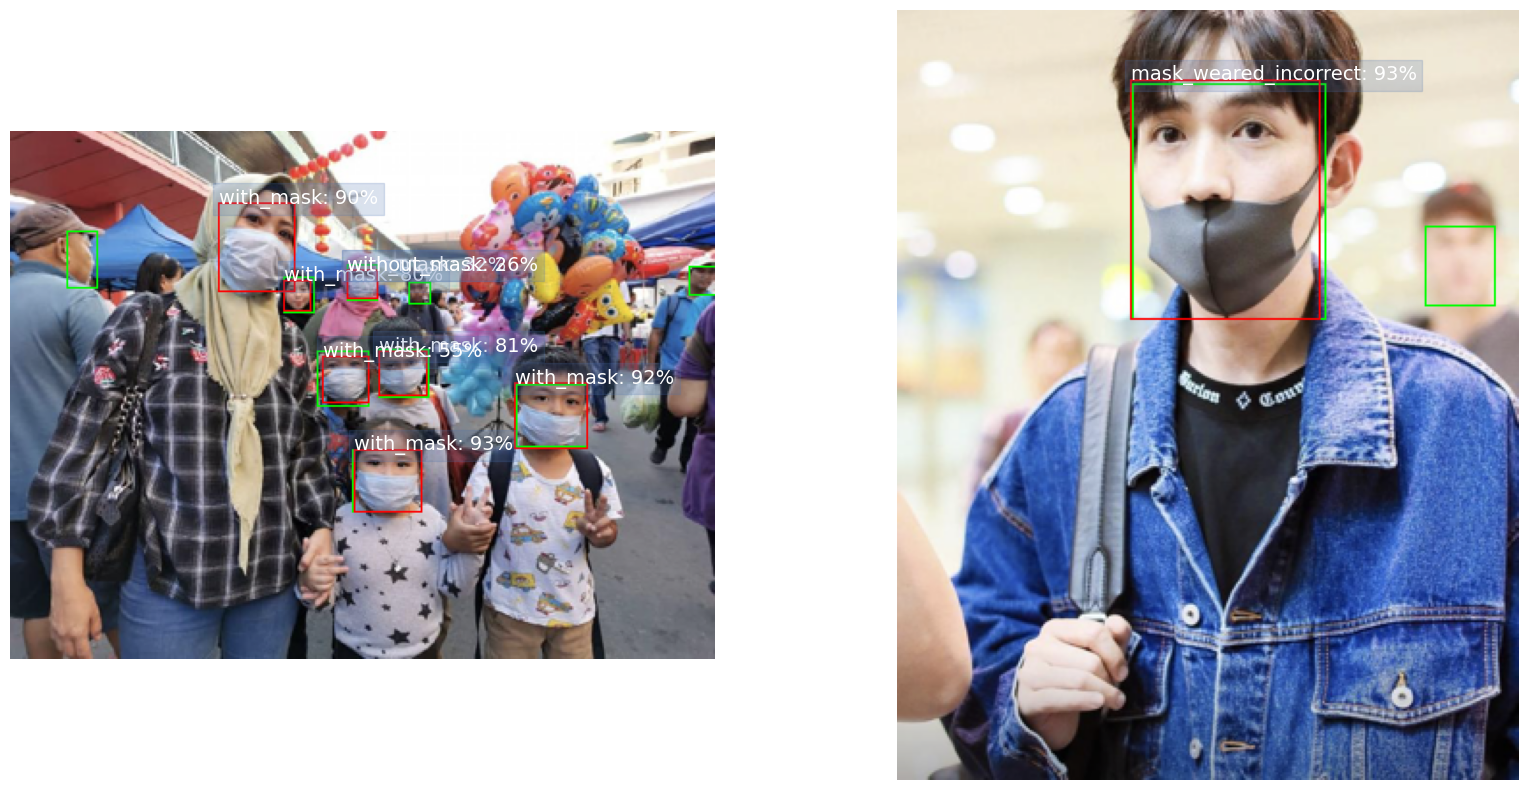

In [26]:
plot_predict_yolo(model, valid_dataloader)

---

## 4. Conclusion 

| Model | No. of parameters | GFLOPS| mAP | minor class AP | mAP50  | One epoch training time |
|---|---|---|---|---|---|---|
| Faster R-CNN | 41.8 mln  | 134 | 0.53  | 0.39 | 0.79  | 2.4 min |
| YOLOv8 | 25.9 mln | 79 | 0.68 | 0.69 | 0.92 | 0.5 min |


The table shows that by all criteria in our case YOLOv8 has shown better results than Faster R-CNN. The YOLO model is faster than Faster R-CNN, more accurate, and shows better results for underrepresented classes, the worst case is AP50=0.89 for the class represented as poorly as 3%, while for all the classes mAP50=0.92, and AP50 is almost 0.97 for the major class.

Faster R-CNN is usually considered as a more slow but more accurate model. This case is different. The reason is perhaps in the imbalanced data and the fact that YOLO, since version 7, incorporates the focal loss function, which takes into account class imbalance, and the loss function [is modified for increased accuracy](https://encord.com/blog/yolo-object-detection-guide/) in version 8. Apparently, this approach works better than the weighted loading implemented here for Faster R-CNN.